<a href="https://colab.research.google.com/github/hammaad2002/PerturbationAnalysis/blob/main/Stage_1_(Data_Generation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Disclaimer:**

This notebook is for data generation purpose only. Long story short, this notebook performs attacks and stores all the metadata/information such as clean transcription, ground truth, perturbed transcription ,WER etc. in a google sheet [automatically, no need to manually copy and paste stuff now :) ]. And in the end it will also store the generated perturbed audios in google drive so that those audios can be accessed for further perturbation analysis and defense testing purpose also.

Following is the pipeline describing how the data flows.

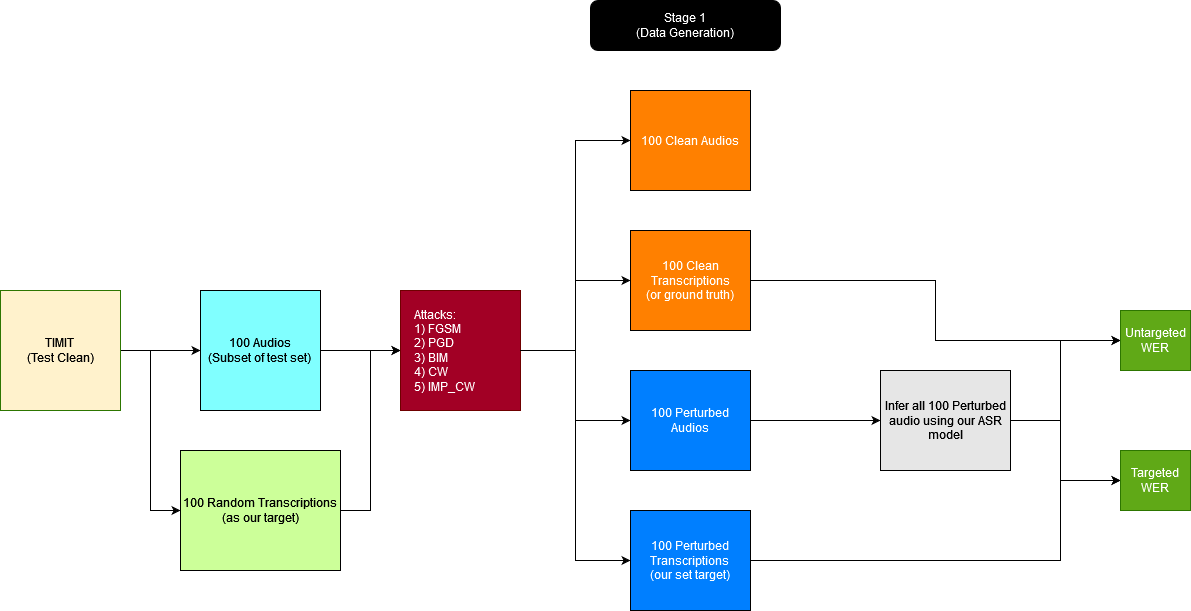

In [ ]:
%%capture
!pip install datasets==1.18.3
!git clone https://github.com/hammaad2002/PerturbationAnalysis.git
!git clone https://github.com/hammaad2002/ASRAdversarialAttacks.git
!pip install gspread==5.9.0
!pip install oauth2client
!pip install gspread-formatting

In [ ]:
from typing import Tuple, List
import random
import h5py
import io
import torch
import torchaudio
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from datasets import load_dataset
from ASRAdversarialAttacks.AdversarialAttacks import ASRAttacks
from PerturbationAnalysis.DataPipeline import DataTransform
import gspread
from google.oauth2.service_account import Credentials
from gspread_formatting import *
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from googleapiclient.http import MediaIoBaseDownload
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# seeding to get same transcription
np.random.seed(170)
random.seed(170)
torch.manual_seed(170)

In [ ]:
%%capture
# downloading TIMIT dataset from datasets library
timit = load_dataset("timit_asr")

In [ ]:
# Loading the model from torchaudio model hub
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model()

# Checking the device available during the current environment (CUDA is recommended!)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initializing attack class
attack = ASRAttacks(model, device, bundle.get_labels())

# Initializing dataTransform class
dataTransformer = DataTransform(model, attack, device)

# Specifying the type of attack and the max number of audios on which to perform attack on
max_aud = 100 # number of example (audios) you want to work with
create_sentences = max_aud # number of audios should be equal to the number of random targeted sentences
sentences_for_random_transcription_vocab = 100 # number of sentences for creating dictionary for creating random transcriptions

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|██████████| 360M/360M [00:02<00:00, 183MB/s] 


In [ ]:
# removing irrelevant columns from TIMIT dataset which we don't need
test_split = timit['test'].remove_columns(["phonetic_detail", "word_detail", "dialect_region", "id", "sentence_type", "speaker_id"])

**For generating random target whose number of words is equal to that of ground truth in batch**

In [ ]:
# generating random target transcription
data = test_split['text']
orig, rand = dataTransformer.random_transcription_generator(data, sentences_for_dict = sentences_for_random_transcription_vocab,
                                                            create_sentences = create_sentences)

In [ ]:
# total number of examples
number_of_examples = max_aud

# Clean Transcription (Ground Truth)

In [ ]:
# displaying top 10 clean sample
for i in range(10):
    print(orig[i])

THE BUNGALOW WAS PLEASANTLY SITUATED NEAR THE SHORE
DON'T ASK ME TO CARRY AN OILY RAG LIKE THAT
ARE YOU LOOKING FOR EMPLOYMENT
SHE HAD YOUR DARK SUIT IN GREASY WASH WATER ALL YEAR
AT TWILIGHT ON THE TWELFTH DAY WE'LL HAVE CHABLIS
EATING SPINACH NIGHTLY INCREASES STRENGTH MIRACULOUSLY
GOT A HECK OF A BUY ON THIS DIRT CHEAP
THE SCALLOPED EDGE IS PARTICULARLY APPEALING
A BIG GOAT IDLY AMBLED THROUGH THE FARMYARD
THIS GROUP IS SECULARIST AND THEIR PROGRAM TENDS TO BE TECHNOLOGICAL


# Target Transcription

In [ ]:
# displaying top 10 target sample
for i in range(10):
    print(rand[i])

WHAT FLEECY YOUR RAG ENORMOUS EMPLOYMENT THEY CAME
EXCESS CLAY PUNCTURING ABOVE BORING WILL WHAT BRING HE NICELY
DOES PROTECTION NEEDED ABOUT NUTRITION
FROM PROSPECTIVE CAN ARE ASSEMBLING MAN EMPLOYMENT AS ME PRESTIGE AS
SPORT AROUND ENTITY ALL WAS LEAVES OVERALLS BRING THEY
MAN TROPICAL PAPER PROSPECTIVE WHO FURTHER
PROVIDE GUESS BUY ON UNLIMITED BRING EXPOSURE HIGH GOVERNING PLANNED
THINNER FIRECRACKERS NIGHTLY EYES SOME FALLOUT
TECHNOLOGICAL DO ASSISTANCE OFTEN ELEGANT PHONY OVERALLS NICELY
ALSO AND EXTRA HIM BURNED APPEALING BREATHED AROUND DEFENDED TRIM NIGHTLY


# FGSM targeted:

adv_attack = "FGSM"

aud = test_split['audio'][:max_aud]

target = rand

clean, pert = dataTransformer.apply_attack(adv_attack, aud, target = target, epsilon = 0.0065, targeted = True)

# FGSM untargeted:

adv_attack = "FGSM"

aud = test_split['audio'][:max_aud]

clean, pert = dataTransformer.apply_attack(adv_attack, aud, epsilon = 0.0065, targeted = False)

# BIM targeted:

adv_attack = "BIM"

aud = test_split['audio'][:max_aud]

target = rand

clean, pert = dataTransformer.apply_attack(adv_attack, aud, target = target, epsilon = 0.0015, alpha = 0.00009,
                                           num_iter = 3000, targeted = True, early_stop = False)
                   
# BIM untargeted:

adv_attack = "BIM"

aud = test_split['audio'][:max_aud]

clean, pert = dataTransformer.apply_attack(adv_attack, aud, epsilon = 0.0015, alpha = 0.00009,
                                           num_iter = 3000, targeted = False, early_stop = False)
                   
# PGD targeted:

adv_attack = "PGD"

aud = test_split['audio'][:max_aud]

target = rand

clean, pert = dataTransformer.apply_attack(adv_attack, aud, target = target, epsilon = 0.0015, alpha = 0.00009,
                                           num_iter = 3000, targeted = True, early_stop = False)

                   
# PGD untargeted:

adv_attack = "PGD"

aud = test_split['audio'][:max_aud]

clean, pert = dataTransformer.apply_attack(adv_attack, aud, epsilon = 0.0015, alpha = 0.00009,
                                           num_iter = 3000, targeted = False, early_stop = False)


# CW targeted:

adv_attack = "CW"

aud = test_split['audio'][:max_aud]

target = rand

clean, pert = dataTransformer.apply_attack(adv_attack, aud, target = target, epsilon = 0.0015, c = 10,
                                          learning_rate = 0.00001, num_iter = 3000, decrease_factor_eps = 1,
                                          num_iter_decrease_eps = 10, optimizer = None, nested = True, 
                                          early_stop = False, search_eps = False, targeted = True)

                   
# CW untargeted:

adv_attack = "CW"

aud = test_split['audio'][:max_aud]

clean, pert = dataTransformer.apply_attack(adv_attack, aud, epsilon = 0.0015, c = 10,
                                          learning_rate = 0.00001, num_iter = 3000, decrease_factor_eps = 1,
                                          num_iter_decrease_eps = 10, optimizer = None, nested = True, 
                                          early_stop = False, search_eps = False, targeted = False)
         
# IMP_CW:

adv_attack = "IMP_CW"

aud = test_split['audio'][:max_aud]

target = rand

clean, pert = dataTransformer.apply_attack(adv_attack, aud, target = target, epsilon = 0.015, c = 10, learning_rate1 = 0.001, 
                                    learning_rate2 = 0.0001, num_iter1 = 100, num_iter2 = 1500, decrease_factor_eps = 1, 
                                    num_iter_decrease_eps = 10, optimizer1 = None, optimizer2 = "Adam",nested = True, 
                                    early_stop_cw = False, search_eps_cw = False, alpha = 0.05)

**Here we are performing targeted FGSM attack but for other attacks the codes are given above.**

**If you want to perform other attack just copy the code from above and paste it in the cell below.**

In [ ]:
#performing attack on our audios in a single line
adv_attack = "FGSM"
aud = test_split['audio'][:max_aud]
target = rand
clean, pert = dataTransformer.apply_attack(adv_attack, aud, target = target, epsilon = 0.0065, targeted = True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# storing all model's clean transcription in separate list
clean_transcriptions = []
for i in tqdm(range(number_of_examples)):
    clean_transcriptions.append(attack.INFER(clean[i]).replace("|"," "))

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# storing all model's perturbed transcription in separate list
perturb_transcriptions = []
for i in tqdm(range(number_of_examples)):
    perturb_transcriptions.append(attack.INFER(pert[i]).replace("|"," "))

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Let's see top 10 clean and perturbed examples
for i in range(10):
    print("Clean: ", clean_transcriptions[i])
    print("Perturbed: ",perturb_transcriptions[i])

Clean:  THE BUNGALOW WAS PLEASANTLY SITUATED NEAR THE SHORE 
Perturbed:  IPONGALO WITH LUT QUIT TET WAY TO TO EGAL 
Clean:  DON'T ASK ME TO CARRY AN OILY RAG LIKE THAT 
Perturbed:  DON'T IAT VERYN EAR TY DRAG LIKE TAT 
Clean:  ARE YOU LOOKING FOR EMPLOYMENT 
Perturbed:  ARE YOU LOOKING FOR FORTHEM 
Clean:  SHE HAD YOUR DARK SUIT AND GREASY WASHWATER ALL YEAR 
Perturbed:  YOU HAD YOUR DARK SUI TREUT YOU WONT FATHER ALL YEAR 
Clean:  AT TWILIGHT ON THE TWELFTH DAY WE'LL HAVE SHIBLI 
Perturbed:  AT TWILIGHT ON THE TWELFTH DAY YOU'LL TAK I TI 
Clean:  EATING SPINACH NIGHTLY INCREASES STRENGTH MIRACULOUSLY 
Perturbed:  YOU EXPENDIT FITLY FREEOFRIFOR I 
Clean:  GOT A HECK OF A BY ON THIS DIRT CHEAP 
Perturbed:  GOT A HECK OF A BYE ON HIS  HERD CHEEK 
Clean:  THE SCALLOPED EDGE IS PARTICULARLY APPEALING 
Perturbed:  DELFETIC 
Clean:  A BIG GOAT IDLY AMBLED THROUGH THE FARMYARD 
Perturbed:  A PIG GOAT QIETLY AMPLED THROUGH THE PARMYELD 
Clean:  THIS GROUP IS SECULARIST AND THEIR PROGRAMM TENDS

In [ ]:
# storing WER (between ground truth and perturbed audio's transcription) in a separate list
WER_untargeted = []
for i in tqdm(range(number_of_examples)):
    WER_untargeted.append(100*attack.wer_compute([orig[i]], [pert[i].numpy()], targeted= False)[0])

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
print([WER_untargeted[i] for i in range(10)])

[100.0, 90.0, 20.0, 54.54545454545454, 40.0, 100.0, 40.0, 100.0, 50.0, 81.81818181818183]


In [ ]:
# storing WER (between our set target and perturbed audio's transcription) in a separate list [This is basically TMR in a nutsell]
WER_targeted = []
for i in tqdm(range(number_of_examples)):
    WER_targeted.append(100*attack.wer_compute([rand[i]], [pert[i].numpy()], targeted= True)[0])

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
print([WER_targeted[i] for i in range(10)])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# storing insertions, substitutions, and deletions in all in their separate lists
insertions = []
substitutions = []
deletions = []
for i in tqdm(range(number_of_examples)):
    info = attack.wer_compute([orig[i]], [pert[i].numpy()], targeted= False)[1]
    insertions.append(info[0][1])
    substitutions.append(info[0][0])
    deletions.append(info[0][2])

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
print([insertions[i] for i in range(10)])

[1, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [ ]:
print([substitutions[i] for i in range(10)])

[8, 7, 1, 6, 3, 5, 4, 1, 4, 7]


In [ ]:
print([deletions[i] for i in range(10)])

[0, 2, 0, 0, 0, 1, 0, 5, 0, 2]


In [ ]:
# signal to noise ratio function for computing SNR (it really is noise to signal ratio the way it is computed)
def Metricsnr(original, noisy):
    original_power = 20 * np.log10(np.mean(original ** 2))
    noise_power = 20 * np.log10(np.mean((original - noisy) ** 2))
    snr = noise_power - original_power
    return snr

In [ ]:
# storing SNR information in a separate list
snr = []
for i in tqdm(range(number_of_examples)):
    temp1=clean[i].numpy()
    temp2=pert[i].numpy()
    snr.append(Metricsnr(temp1,temp2))

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
print([snr[i] for i in range(10)])

[-11.378765106201172, -0.38451194763183594, -8.605523109436035, -12.846879959106445, -7.567400932312012, -2.2128868103027344, -17.3106050491333, -2.9803943634033203, -10.404829978942871, -9.792618751525879]


In [ ]:
# This be used to allocate a separate sheet according to the attack
if adv_attack == "FGSM":
    workingSheetName = 'FGSMTargeted'
elif adv_attack == "BIM":
    workingSheetName = 'BIMTargeted'
elif adv_attack == "PGD":
    workingSheetName = 'PGDTargeted'
elif adv_attack == "CW":
    workingSheetName = 'CWTargeted'
elif adv_attack == "IMP_CW":
    workingSheetName = 'IMP_CWTargeted'

In [ ]:
# All lengths should be equal for storing data
print(len([i for i in range(1,101)]))
print(len(orig))
print(len(rand))
print(len(clean_transcriptions))
print(len(perturb_transcriptions))
print(len(WER_untargeted))
print(len(WER_targeted))
print(len(snr))
print(len(insertions))
print(len(substitutions))
print(len(deletions))

100
100
100
100
100
100
100
100
100
100
100


# Code for storing data directly or automatically in Google Sheet using google-sheet-api without having to manually copy paste all the stuff the old school way

In [ ]:
# Define the scope of API access
scope = [
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive'
]

# Load credentials from JSON key file
creds = Credentials.from_service_account_file(
    '/kaggle/working/PerturbationAnalysis/Credentials/skilled-bonus-389413-02121e893823.json', scopes=scope)

# Authorize client using credentials
client = gspread.authorize(creds)

# Open the existing Google Sheet by name 
sheet_name = 'Results (For comparative analysis)'
worksheet_name = workingSheetName
sh = client.open(sheet_name)
try:
    worksheet = sh.worksheet(worksheet_name)
except gspread.exceptions.WorksheetNotFound:
    worksheet = sh.add_worksheet(title=worksheet_name, rows="100", cols="20")

# Clear the existing content of the worksheet
worksheet.clear()

# Create small Pandas DataFrame (your data may vary)
data = {
    'Index'                                                    : [i for i in range(1,101)],
    'Ground Truth'                                             : orig,
    'Target Transcription'                                     : rand,
    'Transcription of Clean Audio'                             : clean_transcriptions,
    'Transcription of Adversarial Example'                     : perturb_transcriptions,
    'WER (GT vs Adversarial Example)'                          : WER_untargeted,
    'WER (Target Transcription vs Adversarial Examples) [TMR]' : WER_targeted,
    'SNR'                                                      : snr,
    'INSERTION'                                                : insertions,
    'SUBSTITUTION'                                             : substitutions,
    'DELETION'                                                 : deletions
}

df = pd.DataFrame(data)

number_of_columns_to_merge=len(df.columns) # Adding one since we have no index column 

header_label = adv_attack
range_str = "A1:{}1".format(chr(ord('A') + number_of_columns_to_merge - 1))
worksheet.merge_cells(range_str) 
worksheet.update_cell(1, 1, header_label)

# Center align the header
header_format = CellFormat(horizontalAlignment='CENTER')
format_cell_range(worksheet, range_str, header_format)

data=df.values.tolist()
headers=list(df.columns.values)
data.insert(0,[i for i in headers])
worksheet.append_rows(data)

# Find the last row with data
last_row = len(data) + 2

# Add a blank row after the last row with data
blank_row = ['' for _ in range(len(headers))]
worksheet.insert_rows([blank_row], last_row)

# Add new columns with data
new_columns_data = [
    ['AVG OF WER (GT vs Adversarial Example)', 'AVG OF WER (Target Transcription vs Adversarial Examples) [TMR]', 'AVG OF SNR', 'AVG INSERTIONS', 'G SUBSTITUTIONS', 'AVG DELETIONS'],
    [sum(WER_untargeted)/len(WER_untargeted), sum(WER_targeted)/len(WER_targeted), sum(snr)/len(snr), round(sum(insertions)/len(insertions)), round(sum(substitutions)/len(substitutions)), round(sum(deletions)/len(deletions))]]

# Find the last column with data
last_col = len(headers)

# Append new columns data below the first table
for row_idx, row in enumerate(new_columns_data):
    for col_idx, cell_value in enumerate(row):
        worksheet.update_cell(last_row + 1 + row_idx, col_idx + 6, cell_value)

# Storing all the audios in hdf5 extention which does not compress data which could lead to data loss

In [ ]:
filename = '/kaggle/working/' + workingSheetName + '.hdf5'
with h5py.File(filename, 'w') as f:
    for i, audio in enumerate(pert):
        audioName = f"audio{i}"
        f.create_dataset(audioName, data = audio)

# Class that include methods to save and download files from google drive

In [ ]:
class DriveAccess(object):
    def __init__(self, scope, creds):
        scope = scope                                            # Define the scope of API access
        creds = creds                                            # Load credentials from JSON key file
        self.drive_service = build('drive', 'v3', credentials=creds)  # Authorize client using credentials
    
    def _search_file_by_name(self, file_name, folder_id):
        query = f"name='{file_name}' and mimeType!='application/vnd.google-apps.folder' and '{folder_id}' in parents and trashed = false"
        results = self.drive_service.files().list(q=query, fields="nextPageToken, files(id, name)").execute()
        items = results.get('files', [])
        return items

    def _delete_file(self, file_id):
        try:
            self.drive_service.files().delete(fileId=file_id).execute()
            print(f'File with ID "{file_id}" has been deleted.')
        except HttpError as error:
            print(f'An error occurred: {error}')

    # Function to create and upload a file to Google Drive
    def upload_to_drive(self, file_path, file_name, mime_type, folder_id):
        # Check if the file already exists in the folder
        existing_files = self._search_file_by_name(file_name, folder_id)
        if existing_files:
            for file in existing_files:
                self._delete_file(file['id'])

        try:
            file_metadata = {
                'name': file_name,
                'parents': [folder_id]
            }
            media = MediaFileUpload(file_path, mimetype=mime_type)
            file = self.drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()
            print(f'File ID: "{file.get("id")}".')
        except HttpError as error:
            print(f'An error occurred: {error}')
            file = None

        return file.get("id")

    # Function to download a file from Google Drive
    def download_file(self, file_id, destination):
        try:
            request = self.drive_service.files().get_media(fileId=file_id)
            fh = io.BytesIO()
            downloader = MediaIoBaseDownload(fh, request)
            done = False
            while done is False:
                status, done = downloader.next_chunk()
                print("Download %d%%." % int(status.progress() * 100))

            fh.seek(0)
            with open(destination, 'wb') as f:
                f.write(fh.read())
                f.close()
            print(f'Successfully downloaded the file to {destination}')
        except HttpError as error:
            print(f'An error occurred: {error}')

    # Function to list all the files stored in my Google Drive's folder
    def list_files_in_folder(self, folder_id):
        query = f"'{folder_id}' in parents and trashed = false"
        results = self.drive_service.files().list(q=query, fields="nextPageToken, files(id, name)").execute()
        items = results.get('files', [])
        return items

In [ ]:
# initializing DriveAccess class
driveScope = [scope[1]]
drive = DriveAccess(scope, creds)

In [ ]:
# Upload the .hdf5 file to Google Drive [basically the perturbed audios are being stored in drive :) ]
file_path = filename
file_name = workingSheetName + '.hdf5'
mime_type = 'application/octet-stream'
folder_id = '1NI0ZylqR35rDNJkUpERJTnBX86MSLFhP'
file = drive.upload_to_drive(file_path, file_name, mime_type, folder_id)

File with ID "1Zz8g6OmSgVezVaBpW5RyO3AQuNuf5JRm" has been deleted.
File ID: "1F8mLD7dIm8hzNFcjBJsZRvejbZ3J25oj".


**Check if the dataset has been stored in the drive's folder or not by printing all the file names stored in it**

In [ ]:
# this cell basically prints all the datasets according to the attack type stored in my google drive
files = drive.list_files_in_folder(folder_id)

# storing files names stored in google drive with their corresponding file id in the form of a dictionary
files_dict = {}
for file in files:
    files_dict[file['name']] = file['id']
    print(f"File Name: {file['name']}, File ID: {file['id']}")

File Name: clean.hdf5, File ID: 1LLaiLRaxIk2nQhEBuF0HWmOUyOaI_zPx


These should be the file names if the notebook convention is followed:
1) FGSM   = 'FGSMTargeted.hdf5'

2) BIM    = 'BIMTargeted.hdf5'

3) PGD    = 'PGDTargeted.hdf5'

4) CW     = 'CWTargeted.hdf5'

5) IMP_CW = 'IMP_CWTargeted.hdf5'

**End of data generation. All the information/meta data is saved in google sheet and the audios are also stored in google drive.**

# <center> ******--------******